In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split,\
process_R_results, evaluate_R_forecasts
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp,\
hp_color_plot, plot_forecast_entry, side_by_side_print_forecasts_by_week
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, objectiveFNN
from datetime import datetime
import mxnet as mx
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
mx.random.seed(0)
np.random.seed(0)

In [2]:
base_df = get_data(truncate=False, with_features=True)[1]
#train = data_splits_dict["with_features_2001"][0]
#test = data_splits_dict["with_features_2001"][1]

config = Configuration()
config.train_start_time = datetime(1999,1,1,0,0,0)
config.train_end_time = datetime(2018,9,30,23,0,0)
config.test_end_time = datetime(2020,9,30,23,0,0)
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
locations = list(base_df.location.unique())

# R forecasts

In [3]:
results_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/validation_results.csv", sep=',')
processed_df = process_R_results(config, results_df, influenza_df, validation=True)

In [4]:
df_dict = {"hhh4":{1:processed_df[processed_df.WeekAhead == 1].copy(),
                   2:processed_df[processed_df.WeekAhead == 2].copy(),
                   3:processed_df[processed_df.WeekAhead == 3].copy(),
                   4:processed_df[processed_df.WeekAhead == 4].copy()}}
evaluator_df = evaluate_R_forecasts(config, df_dict["hhh4"], locations, processed_df)

Evaluating 1/4 -- 2023-06-03 14:17:38.453437
Evaluating 2/4 -- 2023-06-03 14:18:54.577712
Evaluating 3/4 -- 2023-06-03 14:20:13.641985
Evaluating 4/4 -- 2023-06-03 14:21:29.689170


# Default forecasts

In [5]:
results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/default_models_validation.npy',allow_pickle='TRUE').item()
forecasts_dict, evaluator_df_dict = forecast_by_week(config, None, None, locations, models_dict = {"DeepAR":None, "FNN":None}, seed=0, results_dict=results_dict)

Running evaluation: 411it [00:03, 124.07it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 116.31it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 116.25it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 122.05it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 126.78it/s

# Tuned Forecasts

In [10]:
tuned_results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/ignore_this_directory/tuned_models_validation.npy',allow_pickle='TRUE').item()
tuned_forecasts_dict, tuned_evaluator_df_dict = forecast_by_week(config, None, None, locations, models_dict = {"Tuned_DeepAR":None, "Tuned_FNN":None}, seed=0, results_dict=tuned_results_dict)

Running evaluation: 411it [00:03, 110.45it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:04, 99.49it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:05, 76.78it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:05, 75.14it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 110.83it/s]
/

# Combine Results

In [13]:
evaluator_df_dict["hhh4"] = evaluator_df
forecasts_dict["hhh4"] = df_dict["hhh4"]
for key in list(tuned_forecasts_dict.keys()):
    forecasts_dict[key] = tuned_forecasts_dict[key]
    evaluator_df_dict[key] = tuned_evaluator_df_dict[key]

DeepAR
          item_id    mean_WIS
0  aggregated {1}  238.896959
0  aggregated {2}  338.585680
0  aggregated {3}  434.091919
0  aggregated {4}  495.709055
FNN
          item_id    mean_WIS
0  aggregated {1}  245.674314
0  aggregated {2}  369.000834
0  aggregated {3}  512.397445
0  aggregated {4}  689.824279
hhh4
          item_id    mean_WIS
0  aggregated {1}  278.018231
1  aggregated {2}  328.183559
2  aggregated {3}  391.242562
3  aggregated {4}  456.233385
Tuned_DeepAR
          item_id    mean_WIS
0  aggregated {1}  236.761418
0  aggregated {2}  324.910271
0  aggregated {3}  377.161592
0  aggregated {4}  411.595099
Tuned_FNN
          item_id    mean_WIS
0  aggregated {1}  282.974557
0  aggregated {2}  375.633837
0  aggregated {3}  468.511627
0  aggregated {4}  536.290233


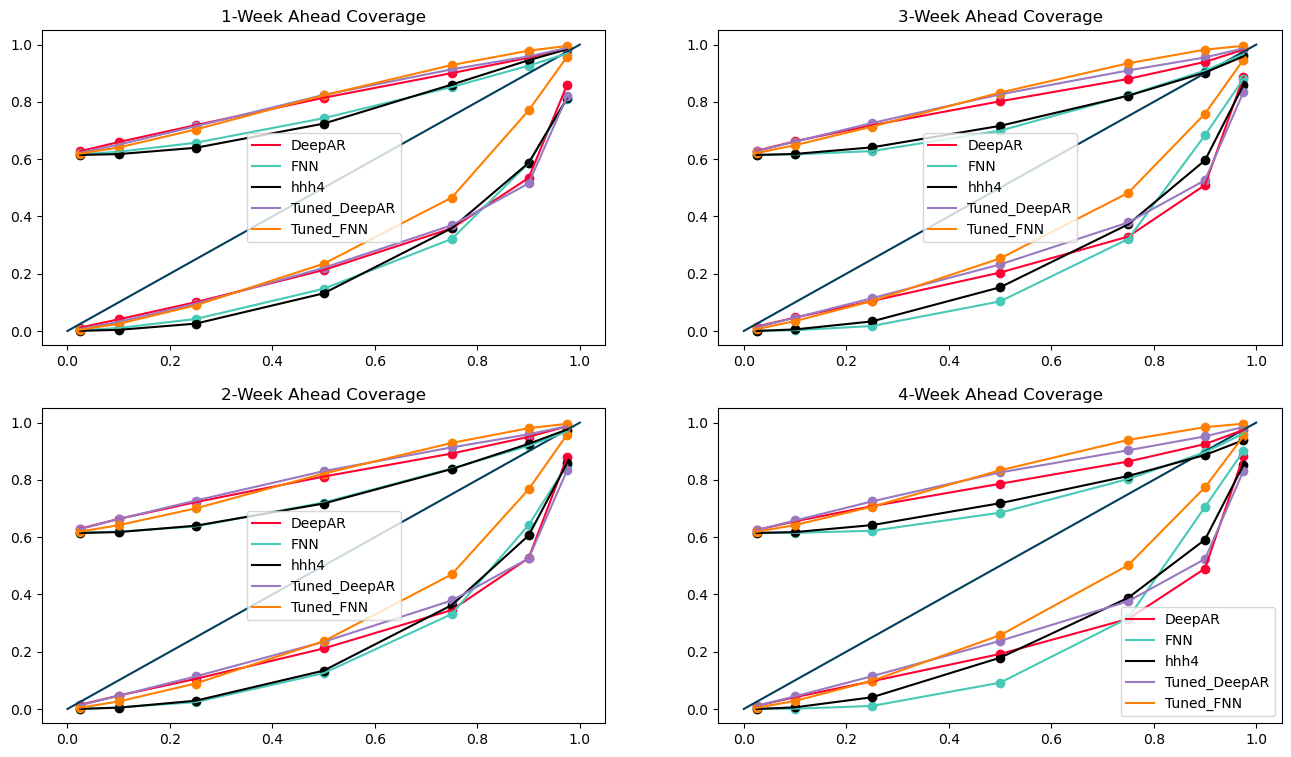

In [37]:
# Plot Coverage
colors = config.colors[:3]+ ["black", "#9979C1", "#FF7F00"] + config.colors[12:12] + config.colors[14:] 
plot_coverage(config, evaluator_df_dict, colors=colors, strict=True)
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
#plt.savefig(f"CoveragePlot.png")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
for key in evaluator_df_dict.keys():
    print(key)
    print(evaluator_df_dict[key].loc[evaluator_df_dict[key]["mean_WIS"]>0, ["item_id","mean_WIS"]])

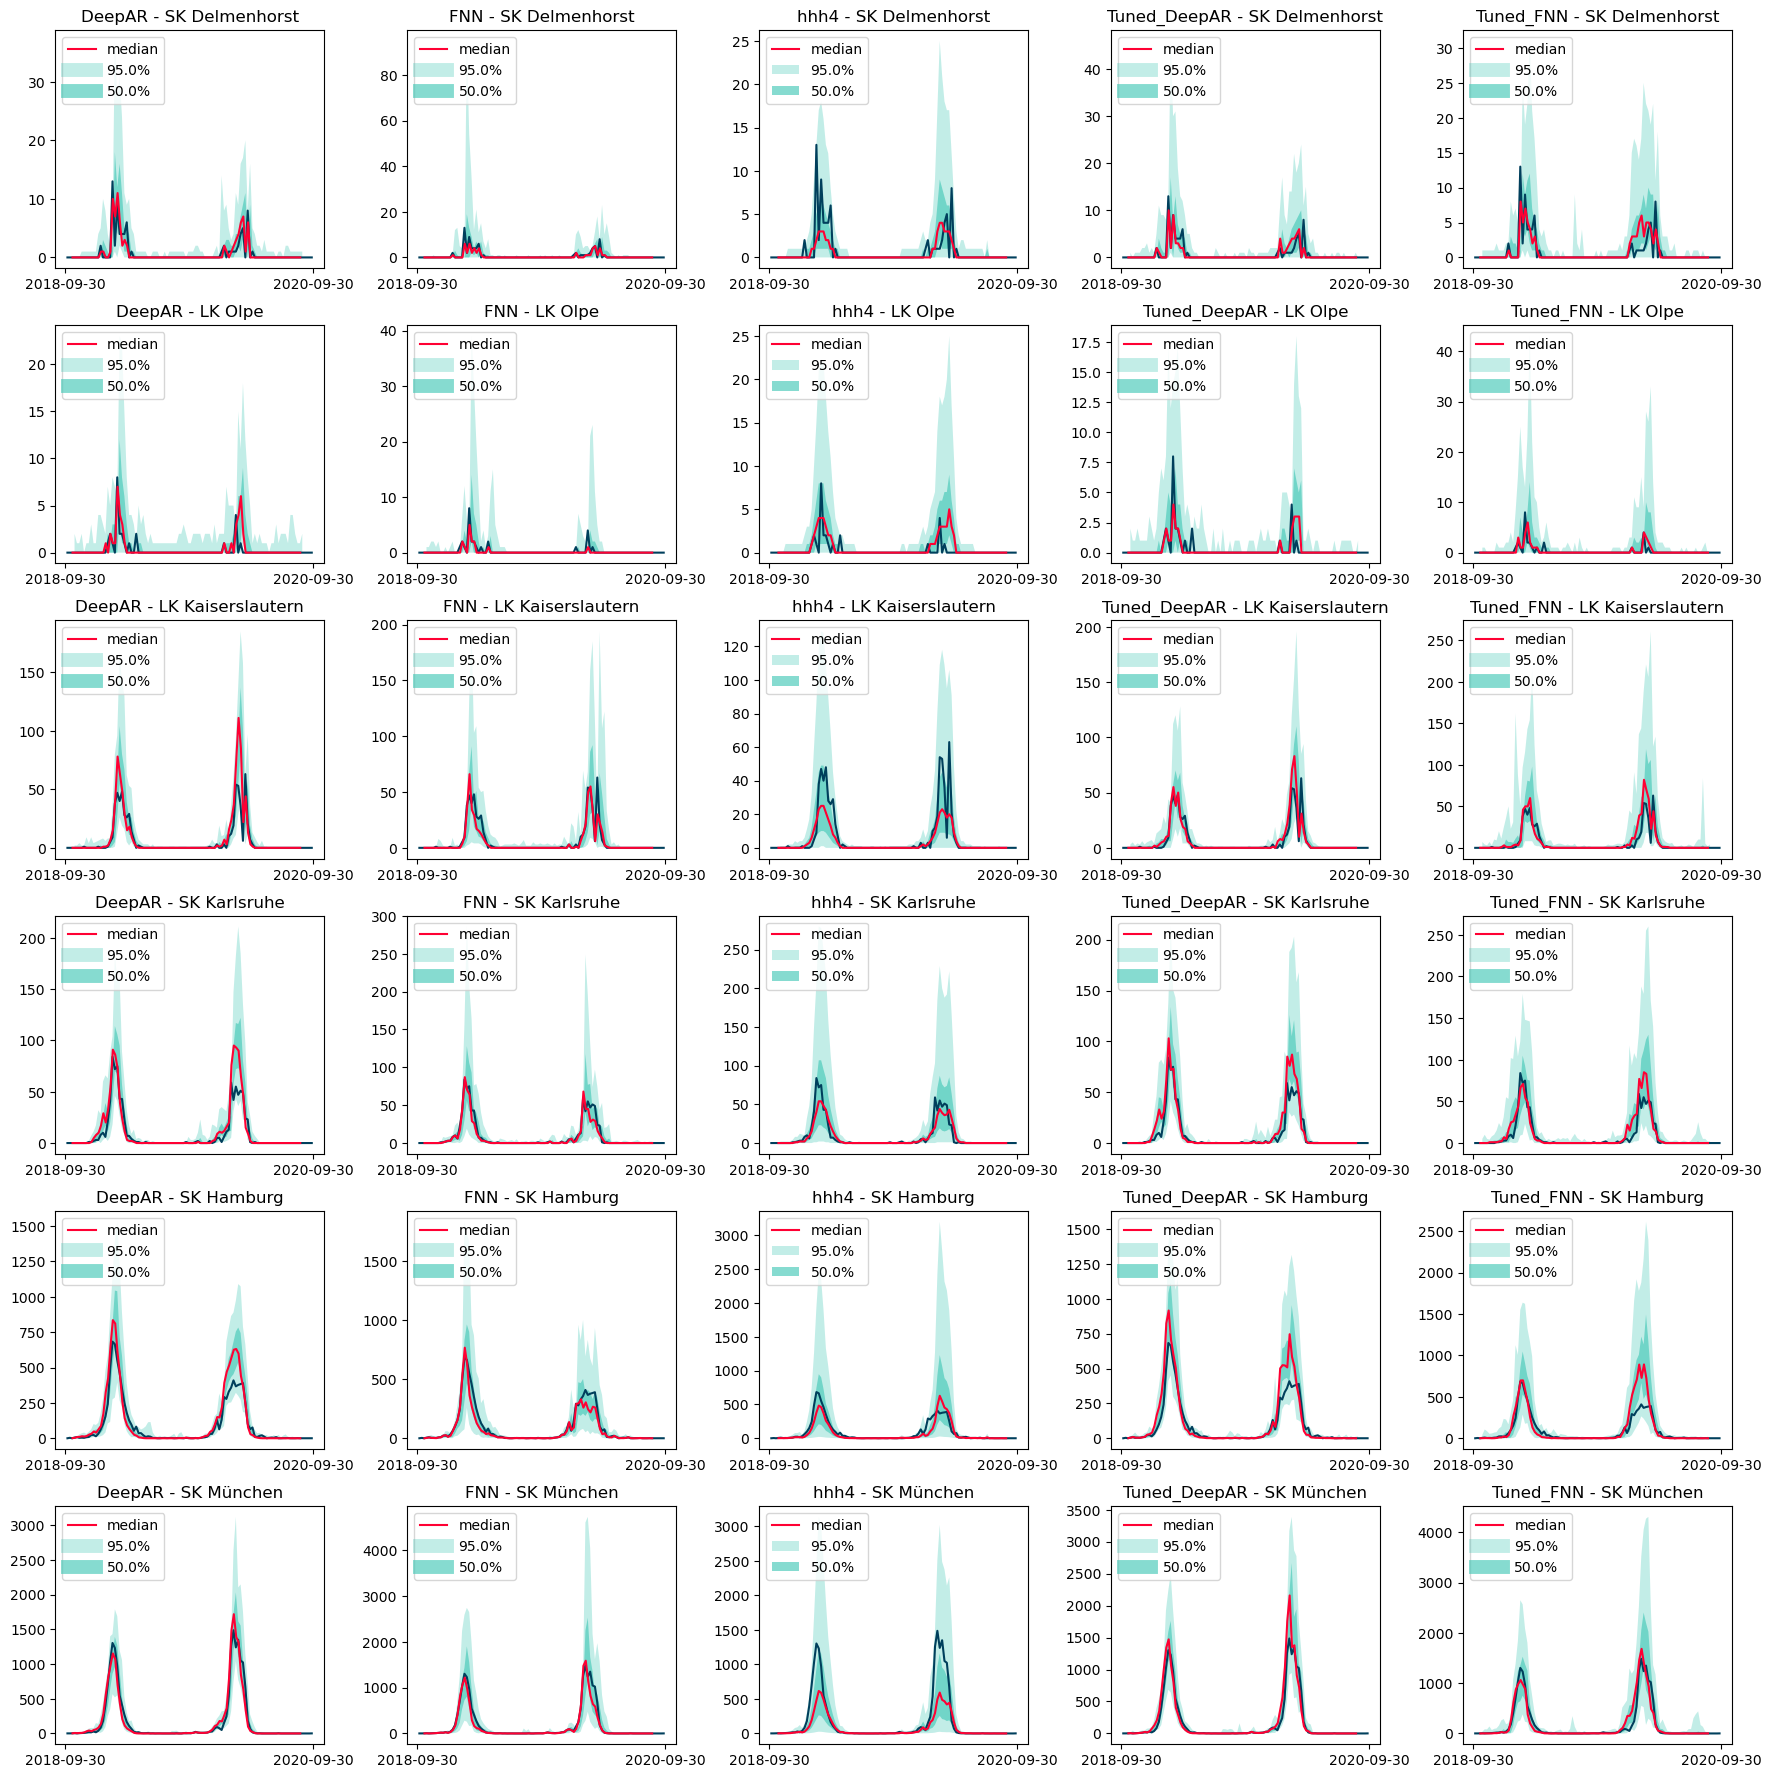

In [25]:
# Plot side by side view of the models
def side_by_side_print_forecasts_by_week1(config, df, forecasts_dict, locations, week_ahead_list, plot_begin_at_trainstart=False, savepath=None, filename=None, figsize=(25, 20)):
    '''
    @Overwritten 
    Prints out plots for the given week-Ahead forecasts of given locations. It needs the initial corrected dataframe, as well as the forecast_dict
    that contains the different week-ahead forecasts.
    The start of the plot time axis, can be set to the training start time (TRUE) or the testing start time (FALSE).
    '''
    if (savepath != None)&(filename!=None):
        import os
    all_locations=list(df.location.unique())
    for week_ahead in week_ahead_list:
        fig, ax = plt.subplots(len(locations), len(list(forecasts_dict.keys())), figsize=figsize)
        fig.tight_layout(pad=2.9)
        for location in locations:
            for key in list(forecasts_dict.keys()):
                row = locations.index(location)
                column = list(forecasts_dict.keys()).index(key)
                plotnumber = [row, column]
                plt.sca(ax[tuple(plotnumber)])
                plt.xticks(rotation=0)
                plt.title(f'{key} - {location}')
                
                if plot_begin_at_trainstart == True:
                    plot_start_time = config.train_start_time
                elif type(plot_begin_at_trainstart)==type(datetime(2016,1,1,1,1,1)):
                    plot_start_time = plot_begin_at_trainstart
                else:
                    plot_start_time = config.train_end_time
                    
                #first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
                plt.plot((df.loc[(df['location'] == location) &
                                        (df.index <= config.test_end_time) &
                                        (df.index >= plot_start_time)].index),
                         df.loc[(df['location'] == location) &
                                       (df.index <= config.test_end_time) &
                                       (df.index >= plot_start_time),'value'], c=config.colors[0])
                #ax[tuple(plotnumber)].grid(which="both")
                # run the overwritten version of the forecast_entry.plot() function to plot to a specific axis and change colors
                forecast_dict = forecasts_dict[key] 
                if key == "hhh4":
                    # Here forecast_entry is a df
                    forecast_entry = forecast_dict[list(forecast_dict.keys())[week_ahead-1]].copy()
                    plot_forecast_entry(config, forecast_entry.loc[forecast_entry["location"]==location], show_mean=False, ax=ax[tuple(plotnumber)], mediancolor=config.colors[1], fillcolor=config.colors[2], axis=True,\
                                        prediction_intervals=(50.0, 95.0), R_entry=True)
                else:
                    # select the right week-ahead forecast entry for a set location
                    forecast_entry = forecast_dict[list(forecast_dict.keys())[week_ahead-1]][all_locations.index(location)]
                    plot_forecast_entry(config, forecast_entry, show_mean=False,ax=ax[tuple(plotnumber)], mediancolor=config.colors[1],fillcolor=config.colors[2], axis=True, prediction_intervals=(50.0, 95.0))
                    #forecast_entry.plot(prediction_intervals=prediction_intervals, color=config.colors[0])
                plt.xticks([config.train_end_time, config.test_end_time], rotation=0, ha="center")
                plt.legend(loc="upper left")
        if (savepath != None)&(filename!=None):
            os.chdir(savepath)
            plt.savefig(f"{filename}Combined_{week_ahead}_WA.png")
            os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
        plt.show()



new_regions = ['SK Delmenhorst','LK Olpe','LK Kaiserslautern','SK Karlsruhe', 'SK Hamburg', 'SK München']
side_by_side_print_forecasts_by_week1(config, base_df, forecasts_dict, new_regions, [1], plot_begin_at_trainstart=False, savepath="/home/reffert/DeepAR_InfluenzaForecast", filename="Comparison", figsize=(18, 22))